In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# start Unity environment
env = UnityEnvironment(file_name="C:/Users/Andre/Desktop/Udacity DRL/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [70]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        '''Creates a 3-layer neural network with input and output size defined by
        state_size and output_size respectively. Hidden layer width is configured by fc1_units and fc2_units.
        
        Arguments
        =========
            state_size (int): size of state space
            action_size (int): size of action space
            seed (int): random seed for result reproducibility
            '''
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed) # Sets the seed for generating random numbers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        '''Performs forward propagation on the QNetwork given a state input, to return action values.'''
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [71]:
class Agent():
    
    def __init__(self, state_size, action_size):#, seed):
        self.state_size = state_size
        self.action_size = action_size
        #self.seed = random.seed(seed)
        
        # Q-network 'brain'
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        
        # Optimizer - notice only used on local qnetwork
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        
        # Timestep counter
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Save the current experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn after every 'update_every' steps
        self.t_step = (self.t_step + 1) % update_every
        
        # if 'update_every' time steps have been reached (modulo division above),
        if self.t_step == 0:
                # and if there are enough samples in memory:
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma)
                
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() # pytorch method for setting a network to evaluation (stop dropout and batchnorm)
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)
    
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [72]:
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size):#, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'action', 'reward', 'next_state', 'done'])
        #self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [111]:
def dqn(n_episodes = 2000, max_t=1000, eps_start=1.0, eps_decay=0.995, eps_end=0.005, brain_name=brain_name):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        
        for t in range(max_t):
        
            action = int(agent.act(state, eps=eps))
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break
    
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_end*eps)

        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

    return scores

In [112]:
#state_size = len(env_info.vector_observations[0])
#action_size = brain.vector_action_space_size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

buffer_size = int(1e6)
batch_size = 64
gamma = 0.95
tau = 1e-3
lr = 5e-4
update_every = 4

In [114]:
agent = Agent(state_size=37, action_size=4)
scores = dqn(n_episodes = 2000)

Episode 100	Average Score: 2.33
Episode 200	Average Score: 7.63
Episode 300	Average Score: 9.72
Episode 400	Average Score: 13.42
Episode 500	Average Score: 13.76
Episode 600	Average Score: 15.02
Episode 700	Average Score: 15.17
Episode 800	Average Score: 14.26
Episode 900	Average Score: 15.76
Episode 1000	Average Score: 15.12
Episode 1100	Average Score: 15.49
Episode 1200	Average Score: 15.71
Episode 1300	Average Score: 15.59
Episode 1400	Average Score: 15.32
Episode 1500	Average Score: 15.71
Episode 1600	Average Score: 16.46
Episode 1700	Average Score: 15.88
Episode 1800	Average Score: 16.64
Episode 1900	Average Score: 16.34
Episode 2000	Average Score: 16.01


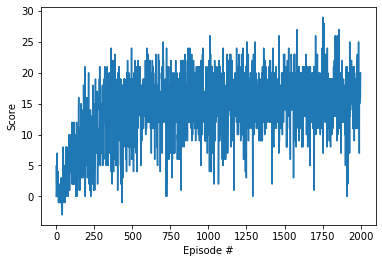

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()